# Benchmarking compiled unit-scaled ops

The objective of this notebook is to benchmark different approaches to using `torch.compile` to fuse various unit-scaled and non-unit-scaled ops. Based on this, we will decide how to implement and advise users on fusing their operations in our library.

The following experiments were run on a SageMaker V100 instance.

In [1]:
!pip install torch==2.0.1

In [2]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from torch.utils.benchmark import Timer
from torch.func import vjp

assert torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dtype = torch.float16
device, torch.cuda.get_device_name(0), torch.__version__

(device(type='cuda', index=0), 'Tesla V100-SXM2-16GB', '2.0.1+cu117')

## Mirco-benchmarks

The aim of this section is to benchmark individual operations. The purpose is to determine whether we should auto-compile scaling factors in with each op, or not.

### Operations to test

Here we test combinations of the following approaches to implementing a ReLU operation:

1. `torch.compile`
2. Custom gradient
3. Unit scaling

The custom gradient can be compiled inside or outside of the fwd/bwd methods, or a combination of both (e.g. the "onion" approach).

We also implement `separate_scaling_ops`, which performs unit scaling by adding separate scaling ops before and after the ReLU with custom gradients.

In [3]:
def basic(x):
    return torch.relu(x)

@torch.compile()
def compiled(x):
    return basic(x)

class CustomGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        ctx.save_for_backward(x)
        return torch.relu(x)

    @staticmethod
    def backward(ctx, grad_y):
        (x,) = ctx.saved_tensors
        return torch.where(x > 0, grad_y, 0.0)

def custom_grad(x):
    return CustomGrad().apply(x)

@torch.compile()
def custom_grad_outer_compiled(x):
    return custom_grad(x)

@torch.compile()
def forward_impl(a):
    return torch.relu(a)

@torch.compile()
def backward_impl(a, z):
    return torch.where(a > 0, z, 0.0)

class CustomGradInnerCompiled(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        ctx.save_for_backward(x)
        return forward_impl(x)

    @staticmethod
    def backward(ctx, grad_y):
        (x,) = ctx.saved_tensors
        return backward_impl(x, grad_y)

def custom_grad_inner_compiled(x):
    return CustomGradInnerCompiled().apply(x)

def basic_mul(x):
    return basic(x) * 2.0

@torch.compile()
def basic_mul_compiled(x):
    return basic_mul(x)

class _FwdScaledGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, fwd_scale):
        return fwd_scale * x

    @staticmethod
    def backward(ctx, grad_y):
        return grad_y, None, None

class _BwdScaledGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, bwd_scale):
        ctx.save_for_backward(torch.tensor(bwd_scale, dtype=x.dtype))
        return x

    @staticmethod
    def backward(ctx, grad_y):
        (bwd_scale,) = ctx.saved_tensors
        return bwd_scale * grad_y, None, None

def separate_scaling_ops(x):
    x = _BwdScaledGrad.apply(x, 0.5)
    x = basic(x)
    return _FwdScaledGrad.apply(x, 2.0)

@torch.compile()
def separate_scaling_ops_compiled(x):
    return separate_scaling_ops(x)

class ScaledCustomGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        ctx.save_for_backward(x)
        return torch.relu(x) * 2.0

    @staticmethod
    def backward(ctx, grad_y):
        (x,) = ctx.saved_tensors
        return torch.where(x > 0, grad_y, 0.0) * 0.5

def scaled_custom_grad(x):
    return ScaledCustomGrad().apply(x)

@torch.compile()
def scaled_custom_grad_outer_compiled(x):
    return ScaledCustomGrad().apply(x)

@torch.compile()
def forward_impl_scaled(a):
    return torch.relu(a) * 2.0

@torch.compile()
def backward_impl_scaled(a, z):
    return torch.where(a > 0, z, 0.0) * 0.5

class ScaledCustomGradInnerCompiled(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        ctx.save_for_backward(x)
        return forward_impl_scaled(x)

    @staticmethod
    def backward(ctx, grad_y):
        (x,) = ctx.saved_tensors
        return backward_impl_scaled(x, grad_y)

def scaled_custom_grad_inner_compiled(x):
    return ScaledCustomGradInnerCompiled().apply(x)

class ScaledCustomGradOnionCompiled(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        ctx.save_for_backward(x)
        return torch.relu(x) * 2.0

    @staticmethod
    def backward(ctx, grad_y):
        (x,) = ctx.saved_tensors
        return backward_impl_scaled(x, grad_y)

@torch.compile()
def scaled_custom_grad_onion_compiled(x):
    return ScaledCustomGradOnionCompiled().apply(x)

# class ScaledCustomGradOnionCompiledVJPa(torch.autograd.Function):
#     @staticmethod
#     def forward(ctx, x):
#         out, vjpfunc = vjp(torch.relu, x)
#         ctx.bwd_fn = torch.compile(vjpfunc)
#         return out

#     @staticmethod
#     def backward(ctx, grad_y):
#         return ctx.bwd_fn(grad_y)


# def scaled_custom_grad_onion_compiled_vjp_a(x):
#     return ScaledCustomGradOnionCompiledVJPa().apply(x)

# class ScaledCustomGradOnionCompiledVJPb(torch.autograd.Function):
#     @staticmethod
#     def forward(ctx, x):
#         out, vjpfunc = vjp(torch.relu, x)
#         ctx.bwd_fn = vjpfunc
#         return out

#     @staticmethod
#     def backward(ctx, grad_y):
#         return torch.compile(ctx.bwd_fn)(grad_y)


# def scaled_custom_grad_onion_compiled_vjp_b(x):
#     return ScaledCustomGradOnionCompiledVJPb().apply(x)

experiments = {
    'unscaled': [basic, compiled, custom_grad, custom_grad_outer_compiled, custom_grad_inner_compiled],
    'scaled': [basic, compiled, basic_mul, basic_mul_compiled, separate_scaling_ops, separate_scaling_ops_compiled, scaled_custom_grad, scaled_custom_grad_outer_compiled, scaled_custom_grad_inner_compiled, scaled_custom_grad_onion_compiled],
    # 'vjp': [basic, scaled_custom_grad_onion_compiled, scaled_custom_grad_onion_compiled_vjp_a, scaled_custom_grad_onion_compiled_vjp_b]
}

Check to make sure custom grad is correct:

In [4]:
x = torch.randn(2**15, dtype=dtype).to(device)
x1 = x.clone().requires_grad_()
x2 = x.clone().requires_grad_()
y1 = basic(x1)
y2 = custom_grad_inner_compiled(x2)
z = torch.randn(2**15).to(device)
y1.backward(z)
y2.backward(z)

torch.all(x1.grad == x2.grad)

tensor(True, device='cuda:0')

Tried various approaches to benchmark. `torch.utils.benchmark.Timer` appears to be the best. Can confirm that this avoids recording compile time.

In [5]:
def benchmark_fwd(fn, x, runs=5):
    t = Timer(
        stmt=f'{fn.__name__}(x)',
        setup=f'from __main__ import {fn.__name__}',#; {fn.__name__}(x)',
        globals={'x': x}
    )
    return t.timeit(runs).median


def benchmark_bwd(y, x, grad_y, runs=5):
    t = Timer(
        stmt=f'torch.autograd.grad(y, x, grad_y, retain_graph=True)',
        # setup=f'torch.autograd.grad(y, x, grad_y, retain_graph=True)',
        globals={'y': y, 'x': x, 'grad_y': grad_y}
    )
    return t.timeit(runs).median


def measure(fn, input_size):
    x = torch.randn(input_size, dtype=dtype).to(device)
    fwd_time = benchmark_fwd(fn, x)

    _x = torch.randn(input_size, dtype=dtype).requires_grad_().to(device)
    y = fn(_x)
    grad_y = torch.randn_like(y, dtype=dtype).to(device)
    bwd_time = benchmark_bwd(y, _x, grad_y)

    return {'fwd': fwd_time, 'bwd': bwd_time}

In [6]:
min_log_size, max_log_size = 17, 27
sizes = [2**s for s in range(min_log_size, max_log_size + 1)]
data = {}
for experiment_name, experiment_fns in experiments.items():
    data[experiment_name] = {}
    for fn in experiment_fns:
        print(f"Running {fn.__name__}")
        fn_data = {}
        for size in tqdm(sizes):
            fn_data[size] = measure(fn, size)
            # fn_data[size] = measure_2(fn, size)
        data[experiment_name][fn.__name__] = fn_data

Running basic


100%|██████████| 11/11 [00:40<00:00,  3.69s/it]


Running compiled


100%|██████████| 11/11 [00:46<00:00,  4.22s/it]


Running custom_grad


100%|██████████| 11/11 [00:40<00:00,  3.69s/it]


Running custom_grad_outer_compiled


100%|██████████| 11/11 [00:41<00:00,  3.75s/it]


Running custom_grad_inner_compiled


100%|██████████| 11/11 [00:42<00:00,  3.88s/it]


Running basic


100%|██████████| 11/11 [00:40<00:00,  3.68s/it]


Running compiled


100%|██████████| 11/11 [00:40<00:00,  3.69s/it]


Running basic_mul


100%|██████████| 11/11 [00:40<00:00,  3.68s/it]


Running basic_mul_compiled


100%|██████████| 11/11 [00:46<00:00,  4.19s/it]


Running separate_scaling_ops


100%|██████████| 11/11 [00:40<00:00,  3.69s/it]


Running separate_scaling_ops_compiled


100%|██████████| 11/11 [00:49<00:00,  4.46s/it]


Running scaled_custom_grad


100%|██████████| 11/11 [00:40<00:00,  3.68s/it]


Running scaled_custom_grad_outer_compiled


100%|██████████| 11/11 [00:41<00:00,  3.77s/it]


Running scaled_custom_grad_inner_compiled


100%|██████████| 11/11 [00:42<00:00,  3.89s/it]


Running scaled_custom_grad_onion_compiled


100%|██████████| 11/11 [00:41<00:00,  3.76s/it]


In [7]:
from collections import defaultdict

def recursive_defaultdict():
    return defaultdict(recursive_defaultdict)

relative_data = recursive_defaultdict()

for experiment_name, experiment_data in data.items():
    for fn_name, fn_data in experiment_data.items():
        for size, size_data in fn_data.items():
            for direction, time in size_data.items():
                relative_data[experiment_name][direction][fn_name][size] = time


for experiment_name, experiment_data in data.items():
    for fn_name, fn_data in experiment_data.items():
        for size, size_data in fn_data.items():
            for direction in size_data.keys():
                relative_data[experiment_name][direction][fn_name][size] /= data[experiment_name]['basic'][size][direction]

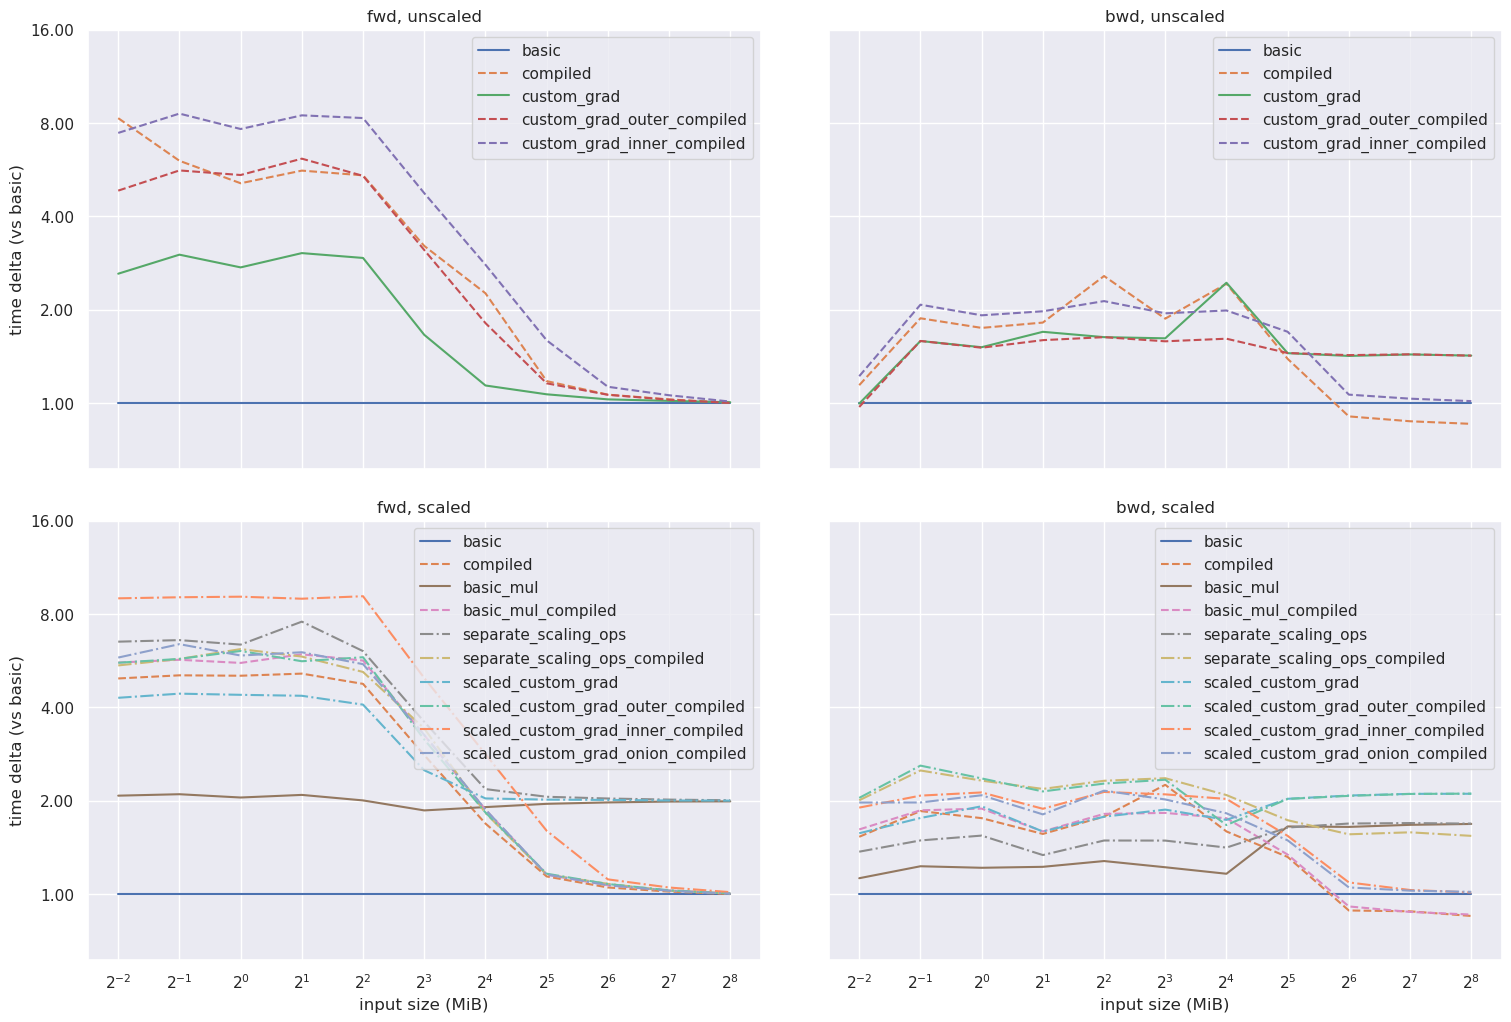

In [8]:
from matplotlib.ticker import ScalarFormatter

sns.set_theme()
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
plt.tight_layout()

bytes_per_elem = {torch.float32: 4, torch.float16: 2}[dtype]
byte_sizes =  [s * bytes_per_elem / (2**20) for s in sizes]

color_iter = iter(sns.color_palette() + sns.color_palette("Set2"))
colors = defaultdict(lambda: next(color_iter))

for row_axs, (experiment_name, experiment_data) in zip(axs, relative_data.items()):
    for ax, (direction, direction_data) in zip(row_axs, experiment_data.items()):
        for fn_name, fn_data in direction_data.items():
            if 'scal' in fn_name:
                dash_type = '-.'
            elif 'compiled' in fn_name:
                dash_type = '--'
            else:
                dash_type = '-'
            ax.plot(byte_sizes, fn_data.values(), dash_type, label=fn_name, color=colors[fn_name])
        ax.set_xscale('log', base=2)
        ax.set_yscale('log', base=2)
        # ax.xaxis.set_major_formatter(ScalarFormatter())
        ax.yaxis.set_major_formatter(ScalarFormatter())
        ax.set_ylim(2**-0.7, 2**4)
        ax.set_xlabel('input size (MiB)')
        ax.set_ylabel('time delta (vs basic)')
        ax.set_title(f"{direction}, {experiment_name}")
        ax.label_outer()
        ax.legend(loc='upper right')
        ax.set_xticks(byte_sizes)

### Conclusions

Context: the $2^6 - 2^7$ window is "large model size". This is what Pythia uses for all its experiments.

Bear in mind, _these conclusions only consider the pros/cons of compiling a single scaled op_ (the following section considers compilation of multiple ops). The key question is whether we should auto-compile scaling factors in with each op, or not.

#### Non-unit scaling

These experiments simply implement & compile a basic ReLU. One might assume all approaches give the same results, however:

1. **For small models, `torch.compile` is slower** in both passes. It adds up to 3x overhead for a simple ReLU.
2. **For large models, `torch.compile` is faster** in the backward pass. This improvement is minor.
3. **Custom grads are slower**. For the forward pass, this is only true for small models. For the backward pass, small _and_ large models.
4. **If you need a custom grad: for small models don't compile; for large models, inner compile**. Outer compilation fails to get the backward pass compilation speedups.

#### Unit scaling

1. **Adding a simple scalar multiplication gives expected slowdown** (`basic_mul`). In the forward pass this is almost exactly 2x. The backwards pass loads more data, so is slowed less (not clear why uptick for large models).
2. **Compiling with simple scalar multiplication is ~same as compiling without** (`compiled` vs `basic_mul_compiled`). This indicates successful fusion.
3. **Compiling "separate scaling ops" approach helps in forward pass, but not backward** for large models. This is the same problem seen in the backward pass for outer compilation above.
4. **If you need a custom grad: you may as well compile (ideally onion compile)**. Non-compilation will be a bit faster for small models, but it will still be way off the basic implementation - and compiling will help for large models, though only in the backward pass if you inner/onion compile.

Note however, that all of the custom grad scaling implementations require a manual implementation of the backward pass, which is highly undesirable to implement manually for all ops. A side experiment (code above, but disabled here) demonstrated that implementing the backward pass semi-automatically using `vjp` added too-large overheads to be practical.

#### Overall

Unfortunately, with or without compilation, for small models individual unit-scaled ops will be slow due to the custom grads. For larger models, compilation will help, but the only one of the schemes that can reasonably be implemented is the "separate scaling ops" approach. For large models, compilation of "separate scaling ops" helps in the forward pass, but not in the backward (this is a bug, which I have made an [issue for in the PyTorch repo](https://github.com/pytorch/pytorch/issues/101937)).

One thing that's concerning about auto-compilation, is the user experience of playing around with the library and getting hit with long compilations. This could happen separately for every op. Users of a library likely want control over what gets `torch.compile`d. Some users might also not realise that compilation is happening and think the library very slow. This might be tolerable if fusion worked well, but it only really does so for the forward pass of large models.

For these large models, the _real_ speedups from compilation are going to come from compiling larger blocks anyway. Based on this, the current plan is not to compile by default, and to explain to users that although scaling-factor overhead is introduced by the library, it can be mitigated by `torch.compile`. We leave this up to the user, though for large models we'll strongly encourage users to consider applying `torch.compile` to their model (or large blocks within).

## Larger benchmarks

The aim of this section is to analyse the behaviour of compiling multiple unit-scaled ops together. Based on this, we will make recomendations to users about how they should apply `torch.compile`.

The baseline operation to test:

In [3]:
def baseline(x):
    x = torch.relu(x)
    x = torch.relu(x)
    x = torch.relu(x)
    x = torch.relu(x)
    x = torch.relu(x)
    x = torch.relu(x)
    x = torch.relu(x)
    x = torch.relu(x)
    return x

Custom grad version:

In [4]:
def _relu_bwd(x, grad_y):
    return torch.where(x > 0, grad_y, 0.0)

class _CustomGradRelu(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        y = torch.relu(x)
        ctx.save_for_backward(x)
        return y

    @staticmethod
    def backward(ctx, grad_y):
        (x,) = ctx.saved_tensors
        return _relu_bwd(x, grad_y)

def custom_grad(x):
    x = _CustomGradRelu().apply(x)
    x = _CustomGradRelu().apply(x)
    x = _CustomGradRelu().apply(x)
    x = _CustomGradRelu().apply(x)
    x = _CustomGradRelu().apply(x)
    x = _CustomGradRelu().apply(x)
    x = _CustomGradRelu().apply(x)
    x = _CustomGradRelu().apply(x)
    return x

Check to make sure custom grad is correct:

In [6]:
def check_valid_inner(fn):
    x = torch.randn(2**10, dtype=dtype).to(device)
    x1 = x.clone().requires_grad_()
    x2 = x.clone().requires_grad_()
    y1 = baseline(x1)
    y2 = fn(x2)
    z = torch.randn(2**10).to(device)
    y1.backward(z)
    y2.backward(z)
    assert torch.all(y1 == y2), "Invalid"
    assert torch.all(x1.grad == x2.grad), "Invalid"

def check_valid(*fns):
    for fn in fns:
        check_valid_inner(fn)
    print("Valid")

check_valid(custom_grad)

Valid


Simple compiled versions of all the above:

In [7]:
@torch.compile()
def baseline_compiled(x):
    return baseline(x)

@torch.compile()
def custom_grad_compiled_outer(x):
    return custom_grad(x)

check_valid(baseline_compiled, custom_grad_compiled_outer)

Valid


And a more complex double-compilation approach:

In [8]:
@torch.compile()
def _relu_compiled(x):
    return torch.relu(x)

@torch.compile()
def _relu_bwd_compiled(x, grad_y):
    return _relu_bwd(x, grad_y)

class _CustomGradReluCompiled(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        y = _relu_compiled(x)
        ctx.save_for_backward(x)
        return y

    @staticmethod
    def backward(ctx, grad_y):
        (x,) = ctx.saved_tensors
        return _relu_bwd_compiled(x, grad_y)

@torch.compile()
def custom_grad_compiled_double(x):
    x = _CustomGradReluCompiled().apply(x)
    x = _CustomGradReluCompiled().apply(x)
    x = _CustomGradReluCompiled().apply(x)
    x = _CustomGradReluCompiled().apply(x)
    x = _CustomGradReluCompiled().apply(x)
    x = _CustomGradReluCompiled().apply(x)
    x = _CustomGradReluCompiled().apply(x)
    x = _CustomGradReluCompiled().apply(x)
    return x

check_valid(custom_grad_compiled_double)

Valid


We now repeat all of the above, but adding separate forward and backward scaling (except `mul_scalar`, which uses a single scale):

In [9]:
def _relu_scaled(x):
    return torch.relu(x) * 2.0

def mul_scalar(x):
    x = _relu_scaled(x)
    x = _relu_scaled(x)
    x = _relu_scaled(x)
    x = _relu_scaled(x)
    x = _relu_scaled(x)
    x = _relu_scaled(x)
    x = _relu_scaled(x)
    x = _relu_scaled(x)
    return x

In [10]:
def _relu_bwd_scaled(x, grad_y):
    return _relu_bwd(x, grad_y) * 0.5

class _CustomGradReluScaled(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        y = _relu_scaled(x)
        ctx.save_for_backward(x)
        return y

    @staticmethod
    def backward(ctx, grad_y):
        (x,) = ctx.saved_tensors
        return _relu_bwd_scaled(x, grad_y)

def custom_grad_scaled(x):
    x = _CustomGradReluScaled().apply(x)
    x = _CustomGradReluScaled().apply(x)
    x = _CustomGradReluScaled().apply(x)
    x = _CustomGradReluScaled().apply(x)
    x = _CustomGradReluScaled().apply(x)
    x = _CustomGradReluScaled().apply(x)
    x = _CustomGradReluScaled().apply(x)
    x = _CustomGradReluScaled().apply(x)
    return x

In [11]:
@torch.compile()
def mul_scalar_compiled(x):
    return mul_scalar(x)

@torch.compile()
def custom_grad_compiled_outer_scaled(x):
    return custom_grad_scaled(x)

In [12]:
@torch.compile()
def _relu_scaled_compiled(x):
    return _relu_scaled(x)

@torch.compile()
def _relu_bwd_scaled_compiled(x, grad_y):
    return _relu_bwd_scaled(x, grad_y)

class _CustomGradReluScaledCompiled(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        y = _relu_scaled_compiled(x)
        ctx.save_for_backward(x)
        return y

    @staticmethod
    def backward(ctx, grad_y):
        (x,) = ctx.saved_tensors
        return _relu_bwd_scaled_compiled(x, grad_y)

@torch.compile()
def custom_grad_compiled_double_scaled(x):
    x = _CustomGradReluScaledCompiled().apply(x)
    x = _CustomGradReluScaledCompiled().apply(x)
    x = _CustomGradReluScaledCompiled().apply(x)
    x = _CustomGradReluScaledCompiled().apply(x)
    x = _CustomGradReluScaledCompiled().apply(x)
    x = _CustomGradReluScaledCompiled().apply(x)
    x = _CustomGradReluScaledCompiled().apply(x)
    x = _CustomGradReluScaledCompiled().apply(x)
    return x

In [30]:
class _FwdScaledGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, fwd_scale):
        return fwd_scale * x

    @staticmethod
    def backward(ctx, grad_y):
        return grad_y, None, None

class _BwdScaledGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, bwd_scale):
        ctx.save_for_backward(torch.tensor(bwd_scale, dtype=x.dtype))
        return x

    @staticmethod
    def backward(ctx, grad_y):
        (bwd_scale,) = ctx.saved_tensors
        return bwd_scale * grad_y, None, None

def _separate_scale_relu(x):
    x = _BwdScaledGrad.apply(x, 0.5)
    x = torch.relu(x)
    return _FwdScaledGrad.apply(x, 2.0)

@torch.compile()
def _separate_scale_relu_compiled(x):
    return _separate_scale_relu(x)

def separate_scales(x):
    x = _separate_scale_relu(x)
    x = _separate_scale_relu(x)
    x = _separate_scale_relu(x)
    x = _separate_scale_relu(x)
    x = _separate_scale_relu(x)
    x = _separate_scale_relu(x)
    x = _separate_scale_relu(x)
    x = _separate_scale_relu(x)
    return x

@torch.compile()
def separate_scales_compiled(x):
    return separate_scales(x)

@torch.compile()
def separate_scales_compiled_double(x):
    x = _separate_scale_relu_compiled(x)
    x = _separate_scale_relu_compiled(x)
    x = _separate_scale_relu_compiled(x)
    x = _separate_scale_relu_compiled(x)
    x = _separate_scale_relu_compiled(x)
    x = _separate_scale_relu_compiled(x)
    x = _separate_scale_relu_compiled(x)
    x = _separate_scale_relu_compiled(x)
    return x

In [31]:
experiments = {
    'unscaled': [baseline, custom_grad, baseline_compiled, custom_grad_compiled_outer, custom_grad_compiled_double],
    'scaled': [baseline, mul_scalar, custom_grad_scaled, separate_scales, mul_scalar_compiled, custom_grad_compiled_outer_scaled, custom_grad_compiled_double_scaled, separate_scales_compiled],
}

Tried various approaches to benchmark. `torch.utils.benchmark.Timer` appears to be the best. Can confirm that this avoids recording compile time.

In [25]:
def benchmark_fwd(fn, x, runs=5):
    t = Timer(
        stmt=f'{fn.__name__}(x)',
        setup=f'from __main__ import {fn.__name__}',#; {fn.__name__}(x)',
        globals={'x': x}
    )
    return t.timeit(runs).median


def benchmark_bwd(y, x, grad_y, runs=5):
    t = Timer(
        stmt=f'torch.autograd.grad(y, x, grad_y, retain_graph=True)',
        # setup=f'torch.autograd.grad(y, x, grad_y, retain_graph=True)',
        globals={'y': y, 'x': x, 'grad_y': grad_y}
    )
    return t.timeit(runs).median


def measure(fn, input_size):
    x = torch.randn(input_size, dtype=dtype).to(device)
    fwd_time = benchmark_fwd(fn, x)

    _x = torch.randn(input_size, dtype=dtype).requires_grad_().to(device)
    y = fn(_x)
    grad_y = torch.randn_like(y, dtype=dtype).to(device)
    bwd_time = benchmark_bwd(y, _x, grad_y)

    return {'fwd': fwd_time, 'bwd': bwd_time}

In [15]:
min_log_size, max_log_size = 17, 27
sizes = [2**s for s in range(min_log_size, max_log_size + 1)]
data = {}
for experiment_name, experiment_fns in experiments.items():
    data[experiment_name] = {}
    for fn in experiment_fns:
        print(f"Running {fn.__name__}")
        fn_data = {}
        for size in tqdm(sizes):
            fn_data[size] = measure(fn, size)
        data[experiment_name][fn.__name__] = fn_data

Running baseline


100%|██████████| 11/11 [00:42<00:00,  3.86s/it]


Running custom_grad


100%|██████████| 11/11 [00:42<00:00,  3.87s/it]


Running baseline_compiled


  0%|          | 0/11 [00:00<?, ?it/s]/usr/bin/ld: skipping incompatible /usr/lib/libcuda.so when searching for -lcuda
/usr/bin/ld: skipping incompatible /usr/lib/libcuda.so when searching for -lcuda
/usr/bin/ld: skipping incompatible /usr/lib/libcuda.so when searching for -lcuda
100%|██████████| 11/11 [00:50<00:00,  4.58s/it]


Running custom_grad_compiled_outer


100%|██████████| 11/11 [00:45<00:00,  4.13s/it]


Running custom_grad_compiled_double


100%|██████████| 11/11 [00:46<00:00,  4.19s/it]


Running baseline


100%|██████████| 11/11 [00:42<00:00,  3.86s/it]


Running mul_scalar


100%|██████████| 11/11 [00:42<00:00,  3.88s/it]


Running custom_grad_scaled


100%|██████████| 11/11 [00:42<00:00,  3.89s/it]


Running mul_scalar_compiled


100%|██████████| 11/11 [00:50<00:00,  4.62s/it]


Running custom_grad_compiled_outer_scaled


100%|██████████| 11/11 [00:46<00:00,  4.20s/it]


Running custom_grad_compiled_double_scaled


100%|██████████| 11/11 [00:46<00:00,  4.27s/it]


In [32]:
to_rerun = {
    'scaled': [separate_scales_compiled_double],
}

for experiment_name, experiment_fns in to_rerun.items():
    for fn in experiment_fns:
        print(f"Running {fn.__name__}")
        fn_data = {}
        for size in tqdm(sizes):
            fn_data[size] = measure(fn, size)
        data[experiment_name][fn.__name__] = fn_data

Running separate_scales_compiled_double


100%|██████████| 11/11 [00:46<00:00,  4.22s/it]


In [33]:
from collections import defaultdict

def recursive_defaultdict():
    return defaultdict(recursive_defaultdict)

relative_data = recursive_defaultdict()

for experiment_name, experiment_data in data.items():
    for fn_name, fn_data in experiment_data.items():
        for size, size_data in fn_data.items():
            for direction, time in size_data.items():
                relative_data[experiment_name][direction][fn_name][size] = time


for experiment_name, experiment_data in data.items():
    for fn_name, fn_data in experiment_data.items():
        for size, size_data in fn_data.items():
            for direction in size_data.keys():
                relative_data[experiment_name][direction][fn_name][size] /= data[experiment_name]['baseline'][size][direction]

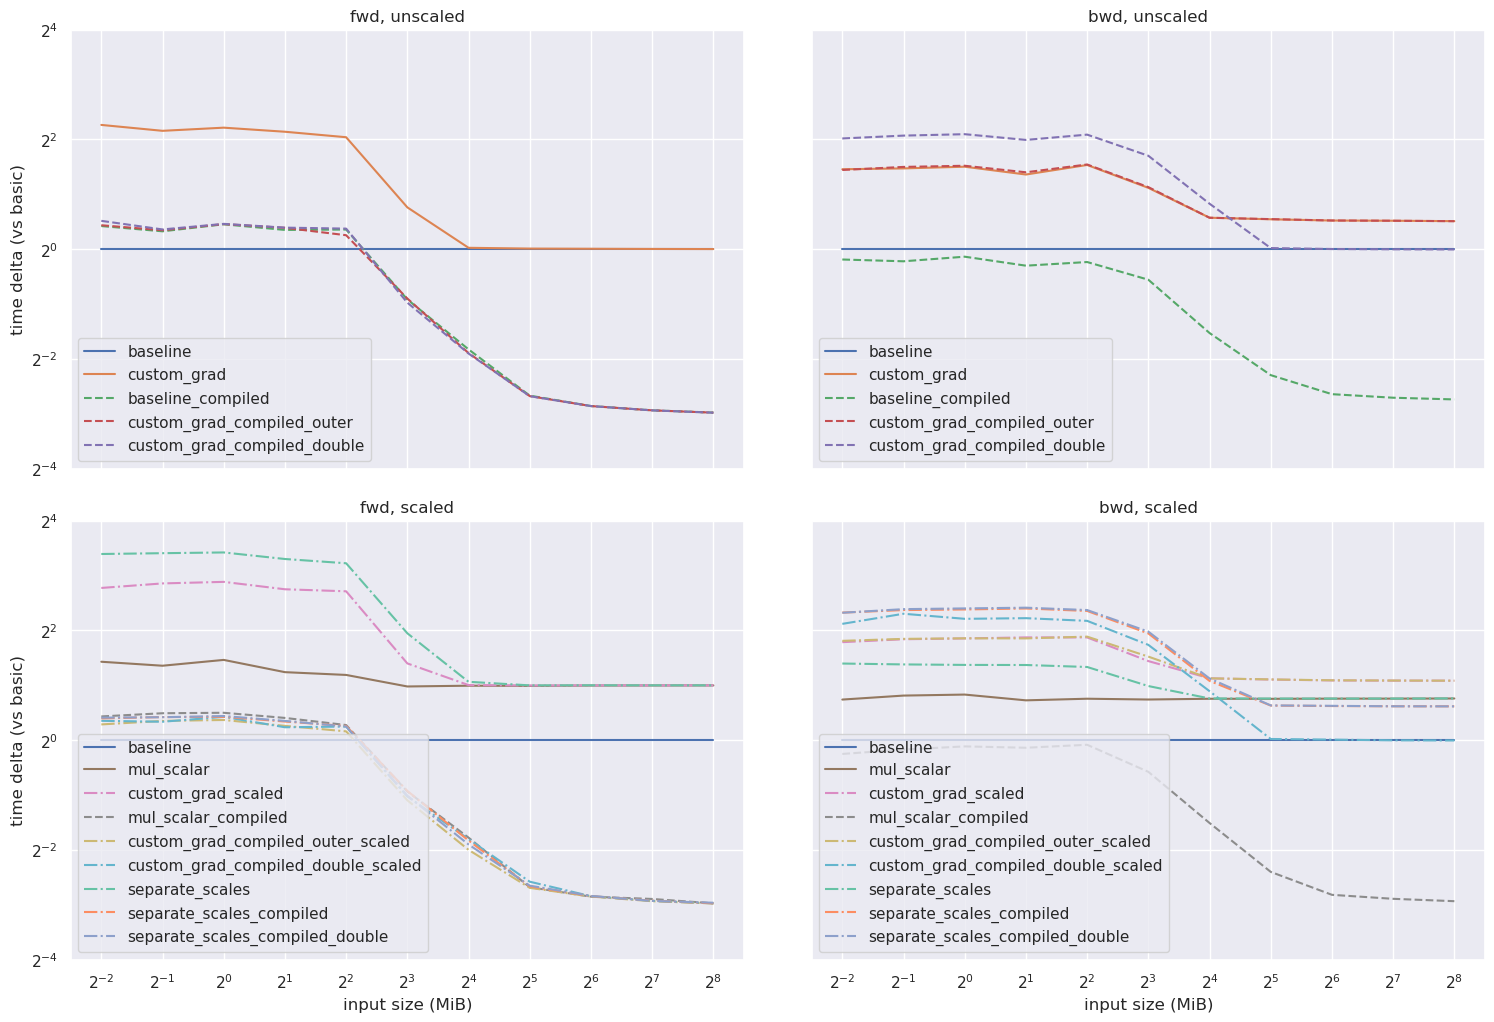

In [35]:
from matplotlib.ticker import ScalarFormatter

sns.set_theme()
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
plt.tight_layout()

bytes_per_elem = {torch.float32: 4, torch.float16: 2}[dtype]
byte_sizes =  [s * bytes_per_elem / (2**20) for s in sizes]

color_iter = iter(sns.color_palette() + sns.color_palette("Set2"))
colors = defaultdict(lambda: next(color_iter))

for row_axs, (experiment_name, experiment_data) in zip(axs, relative_data.items()):
    for ax, (direction, direction_data) in zip(row_axs, experiment_data.items()):
        for fn_name, fn_data in direction_data.items():
            if 'scale' in fn_name:
                dash_type = '-.'
            elif 'compiled' in fn_name:
                dash_type = '--'
            else:
                dash_type = '-'
            ax.plot(byte_sizes, fn_data.values(), dash_type, label=fn_name, color=colors[fn_name])
        ax.set_xscale('log', base=2)
        ax.set_yscale('log', base=2)
        # ax.xaxis.set_major_formatter(ScalarFormatter())
        # ax.yaxis.set_major_formatter(ScalarFormatter())
        ax.set_ylim(2**-4, 2**4)
        ax.set_xlabel('input size (MiB)')
        ax.set_ylabel('time delta (vs basic)')
        ax.set_title(f"{direction}, {experiment_name}")
        ax.label_outer()
        ax.legend(loc='lower left')
        ax.set_xticks(byte_sizes)

### Conclusions

1. **In the forward pass: compiling always helps, and it doesn't matter how you do it**. All methods perform identically. Given this, the easiest-to-implement "separate scales" approach is to be recommended.
2. **In the backward pass: compiling doesn't work with custom grads**. This is a bug, for which [an issue has been created](https://github.com/pytorch/pytorch/issues/101937). Given we need custom grads, we can't avoid this. The "separate scales" approach is just under 2x slower than the baseline, but we have little alternative.